In [1]:
!pip install tqdm

In [2]:
import tensorflow as tf  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, concatenate, Dropout, Lambda, GlobalAveragePooling2D, Dense

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score


from skimage import io
from skimage.transform import resize

import numpy as np

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import cv2

import random
import os
from tqdm import tqdm

from random import randrange

In [3]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, path = "../input/mvtecad-mvtec-anomaly-detection/mvtec_anomaly_detection/leather/",
                 batch_size = 4,
                 input_size=(224, 224),
                 shuffle=True, seed = None, subset = 'training'):
        
        self.image_data_generator = ImageDataGenerator(rescale=1. / 255, data_format='channels_last',
            #width_shift_range = 0.05,
            #height_shift_range = 0.05,
            #brightness_range=(0.95,1.05)
        )
        
        if seed is None:
            random.randint(0, 2**32)
            
        self.batch_size = batch_size
        self.input_size = input_size
        
        self.X_paths = [os.fsdecode(file) for file in os.scandir(f"{path}/train/good")]
        self.X_train, self.X_val = train_test_split(self.X_paths, test_size=0.2, random_state = seed, shuffle = True)
        
        if subset == 'training':            
            self.X = self.X_train
        elif subset == 'validation':
            self.X = self.X_val
            
        self.n = len(self.X)
    
    
    def __getitem__(self, index):
        
        data_x = []
        
        for i in range(self.batch_size):
            image = cv2.imread(self.X[self.batch_size * index + i])
            
            image = self.image_data_generator.random_transform(image)
            
            image = image / 255
            
            image = tf.image.resize(image, self.input_size)
            data_x.append(image)
            
        data_x = np.array(data_x)
        
        return data_x, data_x
    
    def __len__(self):            
        return self.n // self.batch_size

In [4]:
INPUT_SIZE = (224,224)
seed = random.randint(0, 2**32)
train_datagen = CustomDataGen(input_size = INPUT_SIZE, batch_size = 4, seed = seed)
validation_datagen = CustomDataGen(input_size = INPUT_SIZE, subset = "validation", seed = seed) 

In [5]:
#Check we dont have the same images in train and validation sets
any([value in train_datagen.X for value in validation_datagen.X])

False

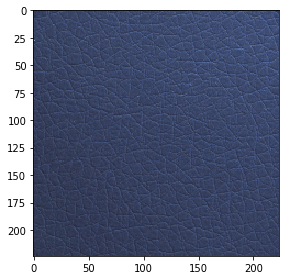

In [6]:
x, y = train_datagen[0]
io.imshow(x[0])
io.show()

In [7]:
input_model_filepath = "../input/anomalysegmentation-weights/anomaly-segmentation-model_vgg19.h5"
output_model_filepath = "./anomaly-segmentation-model.h5"
class AnomalySegmentator(tf.keras.Model):
    def __init__(self, init_layer = 0, end_layer = None):
        super(AnomalySegmentator, self).__init__()
        self.init_layer = init_layer
        self.end_layer = end_layer
        
    def build_autoencoder(self, c0, cd):
        self.autoencoder = Sequential([
            layers.InputLayer((self.map_shape[0]//4, self.map_shape[1]//4, c0)),
            layers.Conv2D((c0 + cd) // 2,(1,1), padding='same', activation = tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.Conv2D(2*cd,(1,1), padding='same', activation = tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.Conv2D(cd,(1,1), padding='same'),
            layers.Conv2D(2*cd,(1,1), padding='same', activation = tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.Conv2D((c0 + cd) // 2,(1,1), padding='same', activation = tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.Conv2D(c0,(1,1), padding='same')            
            
        ])
        
    def build(self, input_shape):
        
        self.vgg = VGG19(include_top = False, weights = 'imagenet', input_shape=input_shape[1:])
        self.features_list = [layer.output for layer in self.vgg.layers if 'conv' in layer.name][self.init_layer:self.end_layer]
        
        self.feature_extractor = Model(inputs = self.vgg.input, 
                                       outputs = self.features_list)
        self.feature_extractor.trainable = False   
        
        self.threshold = tf.Variable(0, trainable = False, dtype = tf.float32)

        self.map_shape = self.features_list[0].shape[1:-1]
        
        self.average_pooling = layers.AveragePooling2D(pool_size=(4, 4), strides=(4,4))       
        
        
        
        self.c0 = sum([feature.shape[-1] for feature in self.features_list])        
        self.cd = 40        
        self.build_autoencoder(self.c0, self.cd)
        
          
    def call(self, inputs):
        features = self.feature_extractor(inputs)
        resized_features = [tf.image.resize(feature, self.map_shape) for feature in features]
        resized_features = tf.concat(resized_features, axis = -1)
        
        resized_features = self.average_pooling(resized_features)

        autoencoder_output = self.autoencoder(resized_features)
        return tf.reduce_sum((autoencoder_output - resized_features)**2, axis = -1)
        
    def reconstruction_loss(self):
        @tf.function
        def _loss(y_true, y_pred):
            loss = tf.reduce_mean(y_pred, axis = (1,2)) / (tf.cast(tf.shape(y_pred)[0], tf.float32) * self.c0)
            return loss
                    
        return _loss

    def compute_threshold(self, data_loader, fpr = 0.05):
        error = []
        for i in tqdm(range(len(data_loader))):
            x, y = data_loader[i]
            error.append(self(x))
        error = np.concatenate(error)
        threshold = np.percentile(error, 100 - fpr)
        self.threshold = tf.Variable(threshold, trainable = False, dtype = tf.float32)
        return error
    
    def compute_pca(self, data_loader):
        extraction_per_sample = 20
        
        extractions = []        
        for i in tqdm(range(len(data_loader))):
            x, _ = data_loader[i]     
            
            features = self.feature_extractor(x)
            resized_features = [tf.image.resize(feature, self.map_shape) for feature in features]
            resized_features = tf.concat(resized_features, axis = -1)

            resized_features = self.average_pooling(resized_features)
            
            for feature in resized_features:
                
                for _ in range(extraction_per_sample):                    
                
                    row, col = randrange(feature.shape[0]), randrange(feature.shape[1])
                    extraction = feature[row, col]
                    extractions.append(extraction)
            
        extractions = np.array(extractions)
        print(f"Extractions Shape: {extractions.shape}")
        pca = PCA(0.9, svd_solver = "full")
        pca.fit(extractions)
        self.cd = pca.n_components_
        self.build_autoencoder(self.c0, self.cd)
        print(f"Components with explainable variance 0.9 -> {self.cd}")
        
    def get_config(self):
        base_config = super().get_config()
        config = {
            "sublayer": keras.saving.serialize_keras_object(self.sublayer),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        sublayer_config = config.pop("sublayer")
        sublayer = keras.saving.deserialize_keras_object(sublayer_config)
        return cls(sublayer, **config)   
        
as_model = AnomalySegmentator()
as_model.compile(Adam(1e-4), loss = as_model.reconstruction_loss())

In [8]:
from tensorflow.keras.utils import register_keras_serializable
import tensorflow as tf
from tensorflow.keras.layers import Layer

class CustomLayer(Layer):
    def __init__(self, factor):
        super().__init__()
        self.factor = factor
    
    def call(self, x):
        return x * self.factor

    def get_config(self):
        return {"factor": self.factor}



In [9]:
as_model.build((None, *INPUT_SIZE,3))
as_model.compute_pca(train_datagen)

80150528/80134624 [==============================] - 0s 0us/step


100%|██████████| 49/49 [00:25<00:00,  1.89it/s]


Extractions Shape: (3920, 5504)
Components with explainable variance 0.9 -> 15


Epoch 1/10
49/49 [==============================] - 32s 576ms/step - loss: 3.3531 - val_loss: 1.0147
Epoch 2/10
49/49 [==============================] - 28s 561ms/step - loss: 0.7514 - val_loss: 0.5070
Epoch 3/10
49/49 [==============================] - 27s 556ms/step - loss: 0.3964 - val_loss: 0.3336
Epoch 4/10
49/49 [==============================] - 27s 553ms/step - loss: 0.3089 - val_loss: 0.2805
Epoch 5/10
49/49 [==============================] - 27s 557ms/step - loss: 0.2570 - val_loss: 0.2351
Epoch 6/10
49/49 [==============================] - 28s 573ms/step - loss: 0.2179 - val_loss: 0.1992
Epoch 7/10
49/49 [==============================] - 27s 560ms/step - loss: 0.1886 - val_loss: 0.1714
Epoch 8/10
49/49 [==============================] - 28s 568ms/step - loss: 0.1628 - val_loss: 0.1501
Epoch 9/10
49/49 [==============================] - 27s 556ms/step - loss: 0.1466 - val_loss: 0.1373
Epoch 10/10
49/49 [==============================] - 29s 598ms/step - loss: 0.1370 - val_lo

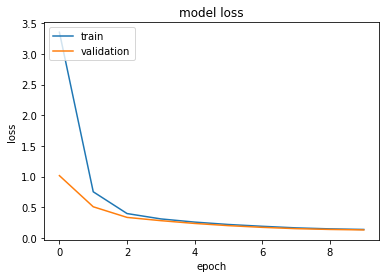

100%|██████████| 49/49 [00:20<00:00,  2.35it/s]


In [10]:
#True if we want to train the model
if True:
    # Training the model
    plateau = tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss', factor=0.5, patience=5, verbose = 2
    )
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=2,
                                          patience=15)  # Early stopping (stops training when validation doesn't improve for {patience} epochs)
    save_best = tf.keras.callbacks.ModelCheckpoint(output_model_filepath, monitor='val_loss', save_best_only=True,
                                                mode='min', save_weights_only = True)  # Saves the best version of the model to disk (as measured on the validation data set)
    
    history = as_model.fit(train_datagen,
        epochs=10,
        validation_data=validation_datagen,
        shuffle=True,
        batch_size=1,
        callbacks=[es, save_best, plateau])
    #Training history
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    as_model.load_weights(output_model_filepath)
    as_model.compute_threshold(train_datagen, fpr=0.01)
    as_model.save_weights(output_model_filepath)
else:
    
    as_model.build((None, *INPUT_SIZE,3))
    as_model.load_weights(input_model_filepath)
    as_model.compute_threshold(train_datagen, fpr=0.01)
    as_model.summary()
    as_model.autoencoder.summary()

In [11]:
classes = ['color', 'cut', 'fold', 'glue','good','poke'] 
test_datagen = ImageDataGenerator(rescale=1. / 255, data_format='channels_last')
test_generator = test_datagen.flow_from_directory("../input/mvtecad-mvtec-anomaly-detection/mvtec_anomaly_detection/leather/test", 
                                                  target_size = INPUT_SIZE,
                                                  batch_size = 2,
                                                  shuffle=False,
                                                  class_mode = 'sparse',
                                                  follow_links=True)

Found 124 images belonging to 6 classes.


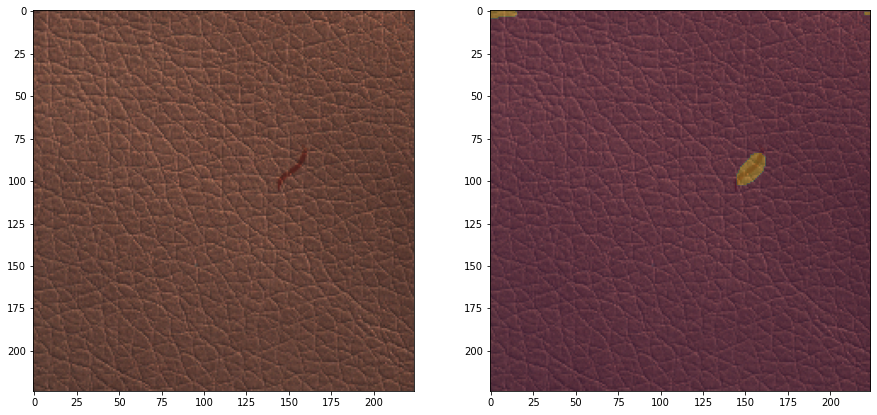

Threshold: 26545.513671875 MaxValue: 37314.703125
GT: color, anomaly detected: True


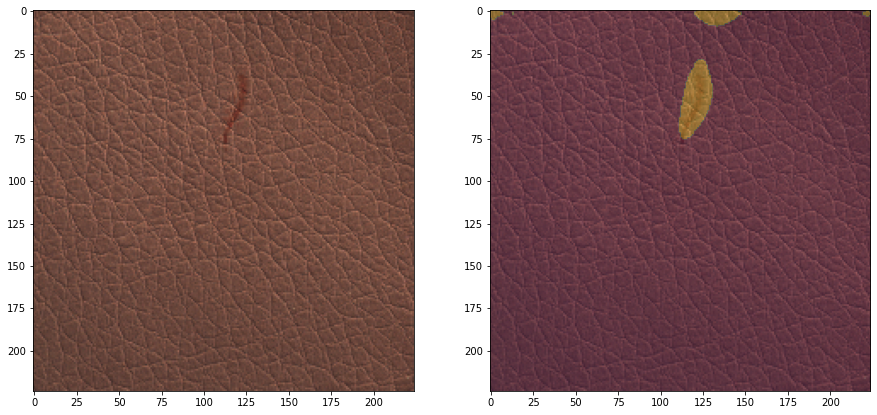

Threshold: 26545.513671875 MaxValue: 45481.93359375
GT: color, anomaly detected: True


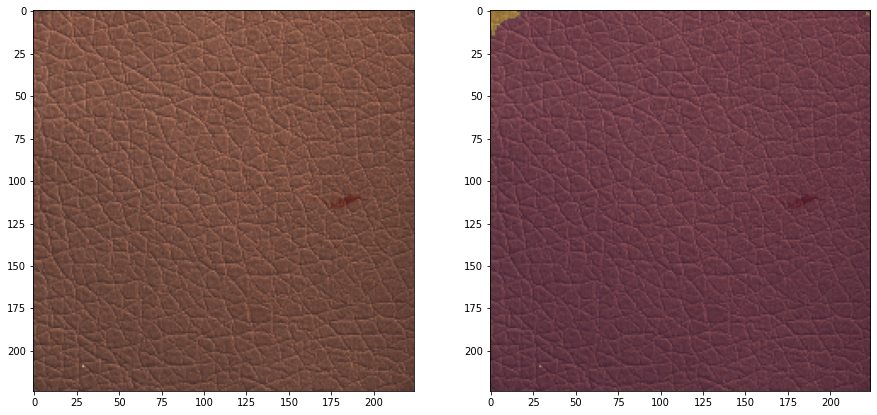

Threshold: 26545.513671875 MaxValue: 35592.3203125
GT: color, anomaly detected: True


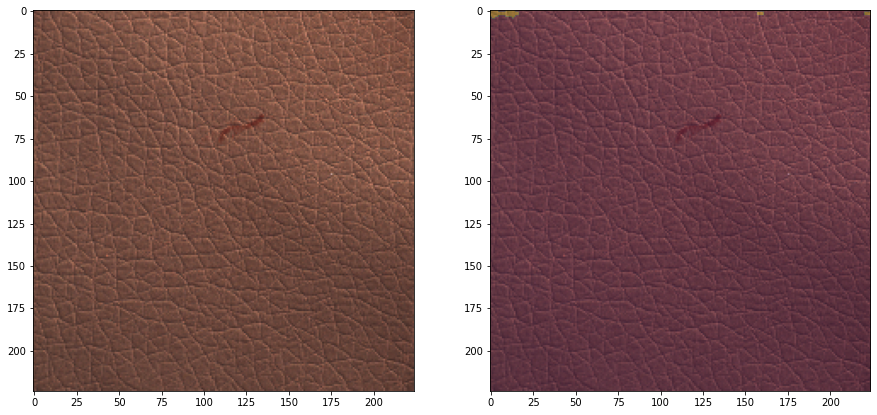

Threshold: 26545.513671875 MaxValue: 29875.703125
GT: color, anomaly detected: True


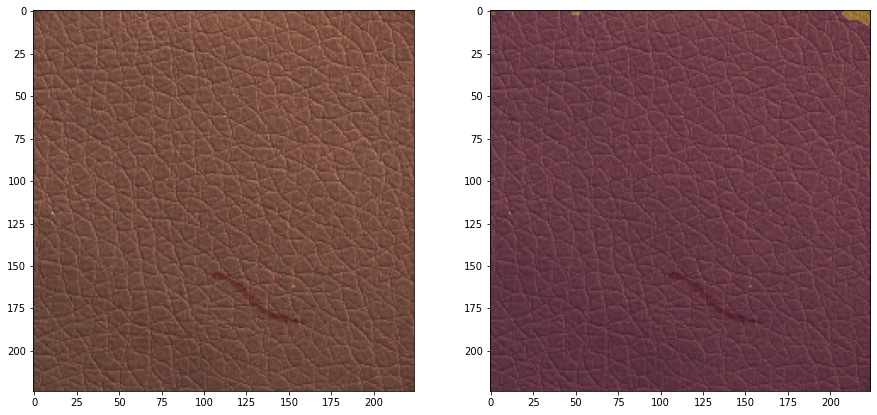

Threshold: 26545.513671875 MaxValue: 34330.125
GT: color, anomaly detected: True


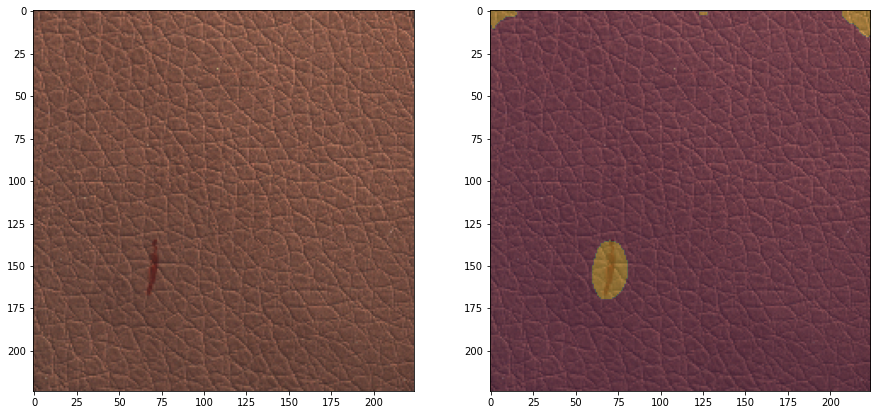

Threshold: 26545.513671875 MaxValue: 66273.578125
GT: color, anomaly detected: True


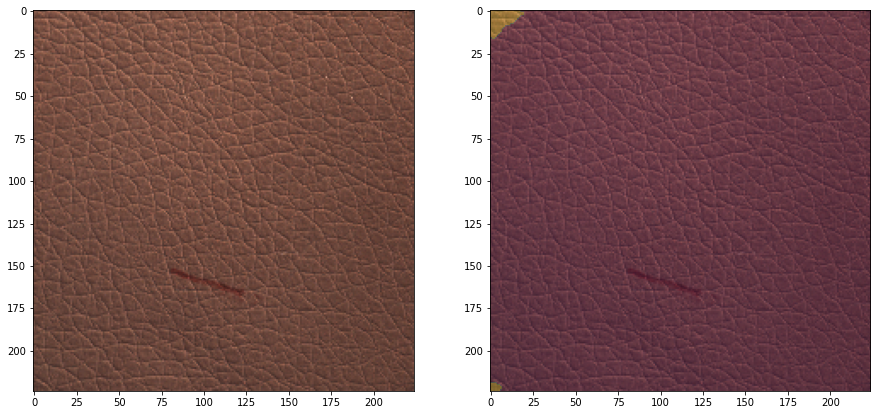

Threshold: 26545.513671875 MaxValue: 45073.0234375
GT: color, anomaly detected: True


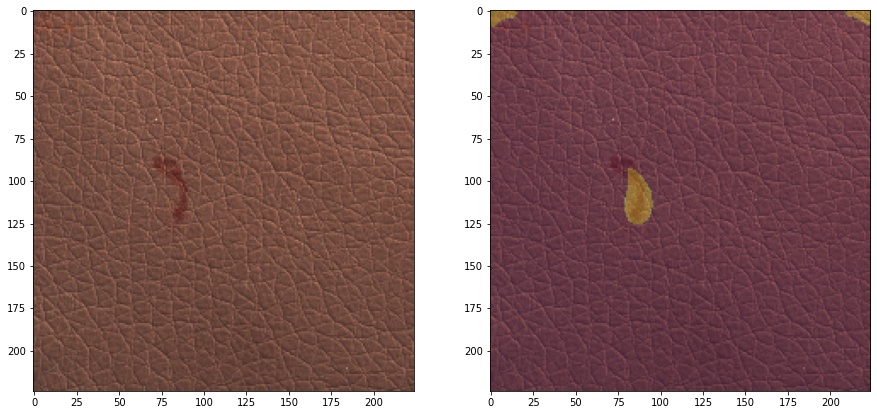

Threshold: 26545.513671875 MaxValue: 44939.86328125
GT: color, anomaly detected: True


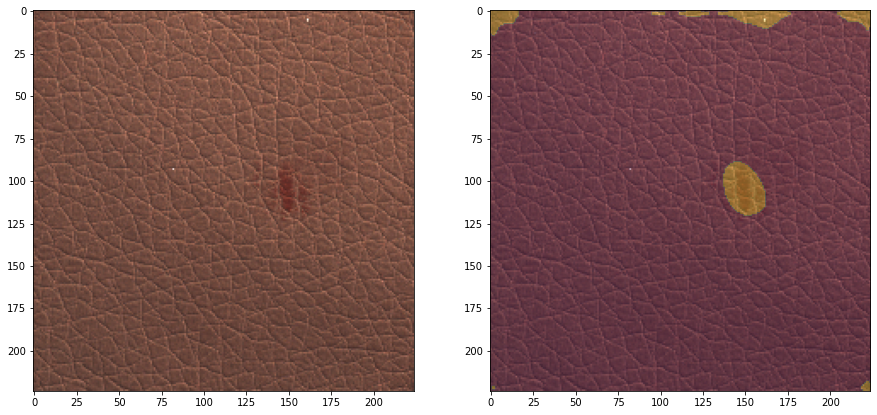

Threshold: 26545.513671875 MaxValue: 52440.0703125
GT: color, anomaly detected: True


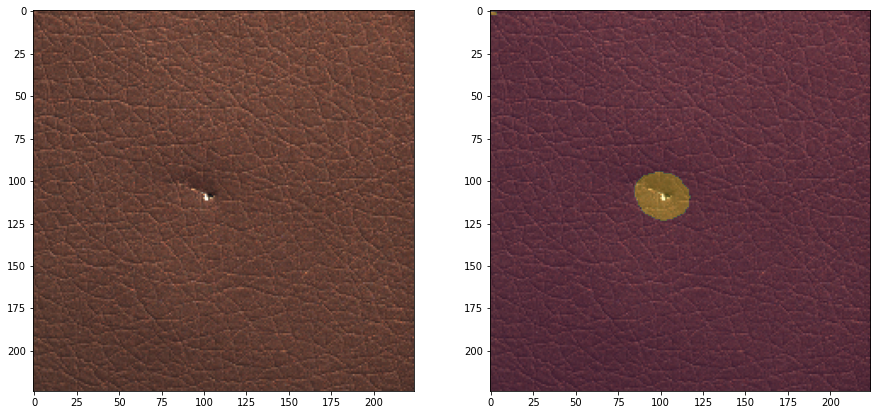

Threshold: 26545.513671875 MaxValue: 150447.734375
GT: cut, anomaly detected: True


In [12]:
for i in range(10):
    x_batch, y_batch = next(test_generator)    
    hotmaps = as_model(x_batch)
    for x, y, hotmap in zip(x_batch, y_batch, hotmaps):
        prediction = np.any(hotmap > as_model.threshold)

    hotmap = resize(hotmap, x.shape[:-1], anti_aliasing = True)
    mask = np.where(hotmap > as_model.threshold, 1, 0)
    

    f, axarr = plt.subplots(1,2, figsize=(15,15))
    axarr[0].imshow(x)
    axarr[1].imshow(mask)
    axarr[1].imshow(x, alpha = 0.75)
    plt.show()

    print(f"Threshold: {as_model.threshold.numpy()} MaxValue: {hotmap.max()}")
    print(f"GT: {classes[int(y)]}, anomaly detected: {prediction}")
    

In [13]:
accuracy = 0
total = 0
for i in range(10):
    x_batch, y_batch = next(test_generator)
    hotmaps = as_model(x_batch)
    for x, y, hotmap in zip(x_batch, y_batch, hotmaps):
        prediction = np.any(hotmap > as_model.threshold)
        accuracy += int(prediction == y)
        total += 1

print(f"Accuracy: {accuracy / total:.4f}")

Accuracy: 0.8000


Enter the image path:  /kaggle/input/image-4/test_image.jpg


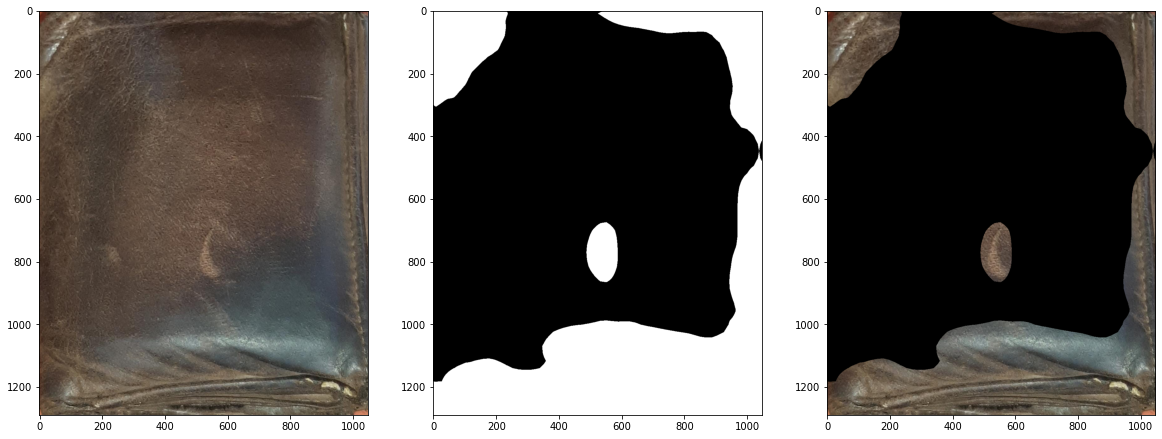

Threshold: 26545.513671875 MaxValue: 154915.28125
Anomaly detected: True


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.transform import resize

# assuming as_model is a model that takes an image and returns a heatmap
# and classes is a list of class names

# get the image path from the user
image_path = input("Enter the image path: ")

# read the image from the path
x = cv2.imread(image_path)
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# resize the image to match the input shape of the model
x_resized = cv2.resize(x, (224, 224))
x_resized = np.expand_dims(x_resized, axis=0) / 255.0  # Normalize the image

# run the model to get the heatmap
hotmap = as_model(x_resized)
hotmap = np.squeeze(hotmap, axis=0)

# resize the heatmap to match the image size
hotmap_resized = resize(hotmap, x.shape[:-1], anti_aliasing=True)

# create a mask from the heatmap
mask = np.where(hotmap_resized > as_model.threshold, 1, 0)

# apply the mask to the image
segmented_image = x * np.stack([mask]*3, axis=-1)

# plot the original image, mask, and segmented image
f, axarr = plt.subplots(1, 3, figsize=(20, 20))
axarr[0].imshow(x)
axarr[1].imshow(mask, cmap='gray')
axarr[2].imshow(segmented_image)
plt.show()

# print the threshold and max value of the heatmap
print(f"Threshold: {as_model.threshold.numpy()} MaxValue: {hotmap_resized.max()}")

# print the anomaly detection result
prediction = np.any(hotmap_resized > as_model.threshold)
print(f"Anomaly detected: {prediction}")


In [20]:
import cv2
import numpy as np

# Load the image
image = cv2.imread(image_path)  # Replace with the actal path

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Find contours in the grayscale image
contours, _ = cv2.findContours(gray_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assuming you want to analyze the largest contour (you can modify this as needed)
largest_contour = max(contours, key=cv2.contourArea)

# Calculate the area of the largest contour
area = cv2.contourArea(largest_contour)

# Calculate the perimeter of the contour
perimeter = cv2.arcLength(largest_contour, True)

# Calculate the aspect ratio of the bounding rectangle
x, y, w, h = cv2.boundingRect(largest_contour)
aspect_ratio = float(w) / h

# Calculate the equivalent diameter of the contour
equivalent_diameter = np.sqrt(4 * area / np.pi)

# Print the results
print(f"Area: {area:.2f} pixels^2")
print(f"Perimeter: {perimeter:.2f} pixels")
print(f"Aspect Ratio: {aspect_ratio:.2f}")
print(f"Equivalent Diameter: {equivalent_diameter:.2f} pixels")

# Get the image shape (height, width, channels)
h, w, _ = image.shape

# Convert the image size from pixels to SI units (e.g., meters)
# Assuming a reference object with a known width (in inches)
known_width = 10  # inches
pixels_per_metric = w / known_width

# Calculate the image size in SI units (meters)
image_width_si = w / pixels_per_metric * 0.0254  # convert inches to meters
image_height_si = h / pixels_per_metric * 0.0254  # convert inches to meters
area_image_si = image_width_si * image_height_si
print('Image width (m): {:.2f}'.format(image_width_si))
print('Image height (m): {:.2f}'.format(image_height_si))
print('Image area (m): {:.2f}'.format(area_image_si))

Area: 1347248.00 pixels^2
Perimeter: 4668.00 pixels
Aspect Ratio: 0.81
Equivalent Diameter: 1309.72 pixels
Image width (m): 0.25
Image height (m): 0.31
Image area (m): 0.08


In [21]:
print(np.unique(mask))
print(np.all(np.logical_or(mask == 0, mask == 1)))
n_white_pixels = np.count_nonzero(mask)
print(n_white_pixels)
known_width = 10  # inches
pixels_per_metric = w / known_width

# Calculate the image size in SI units (meters)
image_width_si = w / pixels_per_metric * 0.0254  # convert inches to meters
image_height_si = h / pixels_per_metric * 0.0254  # convert inches to meters
area_of_single_pixel_m2 = (image_height_si / h) * (image_width_si / w)

# Calculate the total area in square meters
total_area_m2 = n_white_pixels * area_of_single_pixel_m2

print(f"Total area of segmented region (excluding mask): {total_area_m2:.2f} square meters")

[0 1]
True
421003
Total area of segmented region (excluding mask): 0.02 square meters


In [23]:
print('Area of the mask(usable area):',area-n_white_pixels)

Area of the mask(usable area): 926245.0


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class CustomLayer(Layer):
    def __init__(self, factor):
        super().__init__()
        self.factor = factor

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], 1),
                                      initializer='uniform',
                                      trainable=True)

    def call(self, inputs):
        return inputs * self.kernel

class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.custom_layer = CustomLayer(factor=2.0)

    def call(self, inputs):
        return self.custom_layer(inputs)

# Create an instance of the model
as_model = MyModel()

# Save the model in Tensorflow SavedModel format
as_model.save("custom_model.keras", save_format="tf")

# Now, we can simply load without worrying about our custom objects.
reconstructed_model = tf.keras.models.load_model("custom_model.keras")